In [497]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
from dcalib import read_dca1000

In [498]:
# fileName="Sitting1Tx1Rx/static_sitting2.bin"
# fileName="Sitting1Tx1Rx/static_sitting2_Raw_0.bin"
# fileName="Sitting1Tx1Rx/static_sitting_no_breathing3.bin"
# fileName="Sitting1Tx1Rx/nothing.bin"
# fileName="11_30/11_30_forward_nobreathing_58cm_3_Raw_0.bin"
fileName="11_30/11_30_highres_nomovement_nobreathing_59cm_4.bin"
num_samples=640
dca_out=read_dca1000(fileName,num_adc_samples = 640, num_adc_bits = 16, num_rx=1)

In [499]:
dca_out.shape

(1, 20971520)

In [500]:
dca_out2=np.zeros((dca_out.shape[0],dca_out.shape[0]//2),dtype=complex)
dca_out2=dca_out[:,0::2]

In [501]:
dca_out=dca_out2

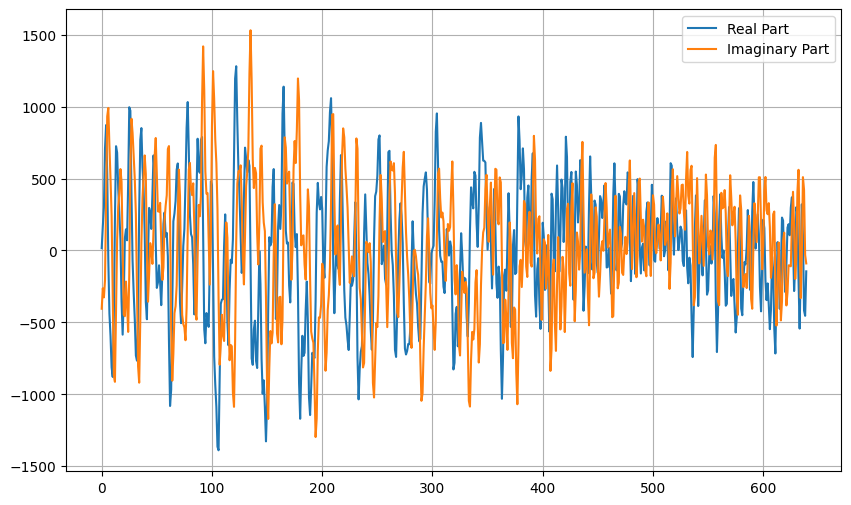

In [502]:
# Time domain
plt.figure(figsize=(10, 6))
chirp=1
data=dca_out[0][chirp*num_samples:(chirp+1)*num_samples]
# data=dca_out2[0][chirp*num_samples:(chirp+1)*num_samples:1]
real=data.real
complex_data=data.imag
plt.plot(real,'-',label='Real Part')
plt.plot(complex_data,'-',label='Imaginary Part')
plt.grid()
plt.legend()

In [503]:
print(dca_out)
print(dca_out.shape)

[[ -16.-428.j   81.-301.j  263.-381.j ... -368.+303.j -369. -88.j
   -58.-126.j]]
(1, 10485760)


In [504]:
3e8/(2*3.5199*1e9)

0.04261484701269922

In [505]:
sampling_frequency = 12000 * 1e3 # Hz (example)
S=65.998 * 1e12 #mhz/us
start_freq=77.396*1e9
ramp_end=60 #us
idle_time=100 #us
periodicity=40 #us
chirp_cycle_time=(idle_time + ramp_end + periodicity) * 1e-6
pulse_repetation_interval = 1/chirp_cycle_time
num_rx=1
num_chirps=1
samples_per_chirp=num_samples
chirps_per_frame=128
range_max=3e8*sampling_frequency/ (2*S)

frames_per_loop=128
chirp_loops=128

dca_out.shape[1]/samples_per_chirp/chirp_loops/frames_per_loop

1.0

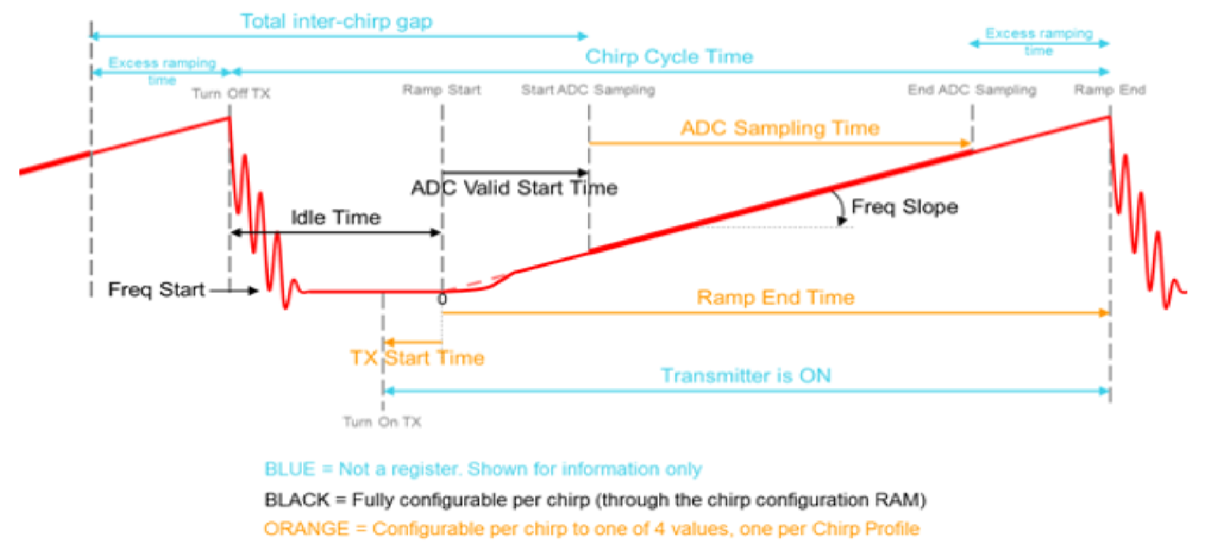

In [506]:
range_max

27.273553744052847

In [507]:
dca_out[0][0]

np.complex128(-16-428j)

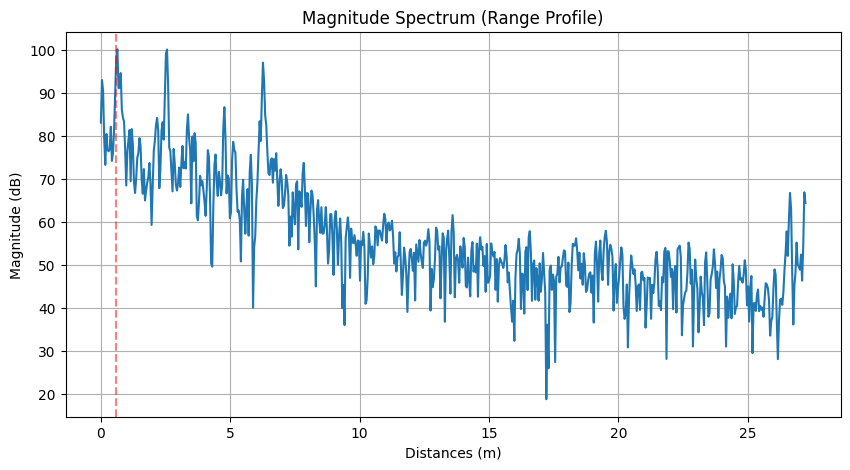

In [508]:
distance_idx=14
# distance_idx=126
def magnitude_dbfs(fft_data, adc_bits=16):
        """
        Convert complex FFT to magnitude in dBFS (decibels relative to full scale)
        
        Args:
            fft_data: Complex FFT output array
            adc_bits: ADC resolution in bits (default 12-bit for typical radar)
        
        Returns:
            magnitude_dbfs: Magnitude in dBFS scale
        """
        # Calculate full scale value based on ADC bits
        full_scale = 2**(adc_bits - 1)  # For signed ADC
        
        # Get magnitude of FFT
        magnitude = np.abs(fft_data)
        
        # Normalize by FFT length (important for proper scaling)
        magnitude_normalized = magnitude / len(fft_data)
        
        # Convert to dBFS: 20*log10(magnitude / full_scale)
        # Add small epsilon to avoid log(0)
        magnitude_dbfs = 20 * np.log10(magnitude_normalized / full_scale + 1e-10)
        
        return magnitude_dbfs

def magnitude_db(fft_data):
        """Convert complex FFT to magnitude in dB"""
        magnitude = np.abs(fft_data)
        magnitude_db = 20 * np.log10(magnitude + 1e-10)  # Add small value to avoid log(0)
        return magnitude_db

def rangeFFT(signal, plot=False):
    global range_max
    num_samples = len(signal)
    window = np.hanning(num_samples)
    signal_windowed = signal * window
    y=np.fft.fft(signal_windowed)
    fft_magnitude = magnitude_db(y,)
    # fft_magnitude = magnitude_dbfs(y,adc_bits=16)

    # frequencies = np.fft.fftshift(np.fft.fftfreq(num_samples, d=1/(sampling_frequency)))
    # distances=np.abs(frequencies)*3e8/2/S
    distances=np.arange(num_samples) * range_max / num_samples
    # print([distances[0],distances[-100]])
    if plot:
        # Plot the magnitude spectrum
        plt.figure(figsize=(10, 5))
        # plt.plot(frequencies[:num_samples//2], fft_magnitude[:num_samples//2]) # Plot only positive frequencies
        # plt.plot(distances[:num_samples//2], fft_magnitude[:num_samples//2]) # Plot only positive frequencies
        plt.plot(distances, fft_magnitude) # Plot only positive frequencies
        plt.title('Magnitude Spectrum (Range Profile)')
        # plt.xlabel('Frequency (Hz) / Range Bins')
        plt.xlabel('Distances (m)')
        plt.ylabel('Magnitude (dB)')
        plt.xticks(np.arange(0,range_max,5))
        plt.grid(True)
        plt.axvline(x=0.6, color='r', linestyle='--', alpha=0.5)
        plt.show()
    return y, fft_magnitude, distances

magAtXXcm=[]
sigAtXXcm=[]
distances_all=[]
rangeFFTAcrossChirps=np.zeros([samples_per_chirp,len(dca_out[0])//samples_per_chirp],dtype=np.complex128)
for chirp_no in range(len(dca_out[0])//samples_per_chirp):
    if chirp_no==0:
        fft_signal, fft_magnitude, distances=rangeFFT(dca_out[0][chirp_no*samples_per_chirp:(chirp_no+1)*samples_per_chirp], plot=True)
    else:
        fft_signal, fft_magnitude, distances=rangeFFT(dca_out[0][chirp_no*samples_per_chirp:(chirp_no+1)*samples_per_chirp], plot=False)
    rangeFFTAcrossChirps[:,chirp_no]=fft_signal
    sigAtXXcm.append(fft_signal[distance_idx]) 
    magAtXXcm.append(fft_magnitude[distance_idx]) 
    distances_all.append(distances[distance_idx])
sigAt58cm=np.array(sigAtXXcm)
magAt58cm=np.array(magAtXXcm)

In [509]:
distances[distance_idx]

np.float64(0.596608988151156)

Text(0, 0.5, 'Magnitude at 0.6m (dB)')

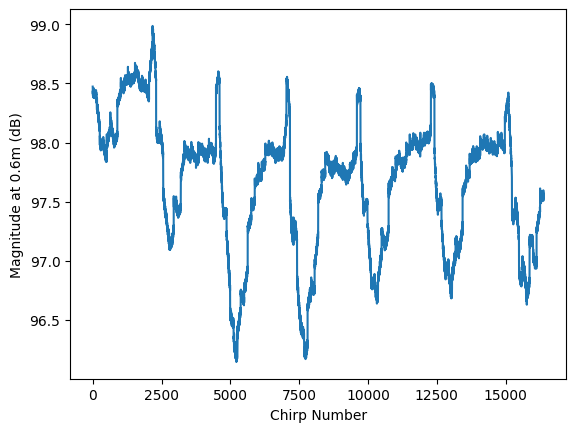

In [517]:
# plt.plot(np.arange(rangeFFTAcrossChirps.shape[1]),magnitude_db(rangeFFTAcrossChirps[3,:]))
# plt.plot(np.arange(len(magAtXXcm[:])),magAtXXcm[:])
plt.plot(np.arange(len(magAtXXcm[:])),magAtXXcm[:])
plt.xlabel('Chirp Number')
plt.ylabel(f'Magnitude at {np.round(distances[distance_idx],2)}m (dB)')

Text(0, 0.5, 'magnitude (dB)')

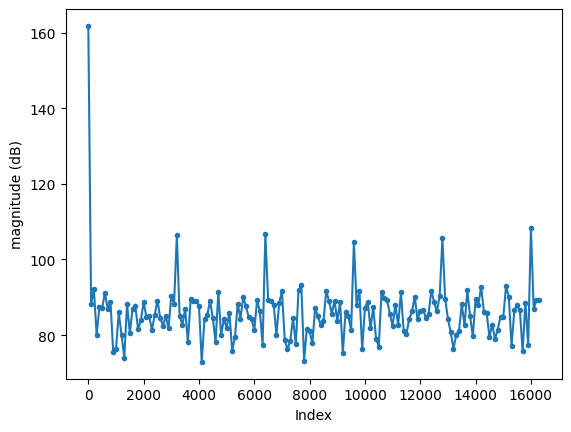

In [511]:
# def dopFFT(signal, plot=False):
#     global range_max
#     num_samples = len(signal)
#     window = np.hanning(num_samples)
#     signal_windowed = signal * window
#     y=np.fft.fft(signal_windowed)
#     fft_magnitude = magnitude_db(y,)
#     # fft_magnitude = magnitude_dbfs(y,adc_bits=16)

#     # frequencies = np.fft.fftshift(np.fft.fftfreq(num_samples, d=1/(sampling_frequency)))
#     # distances=np.abs(frequencies)*3e8/2/S
#     distances=np.arange(num_samples) * range_max / num_samples
#     # print([distances[0],distances[-100]])
#     if plot:
#         # Plot the magnitude spectrum
#         plt.figure(figsize=(10, 5))
#         # plt.plot(frequencies[:num_samples//2], fft_magnitude[:num_samples//2]) # Plot only positive frequencies
#         # plt.plot(distances[:num_samples//2], fft_magnitude[:num_samples//2]) # Plot only positive frequencies
#         plt.plot(distances, fft_magnitude) # Plot only positive frequencies
#         plt.title('Magnitude Spectrum (Range Profile)')
#         # plt.xlabel('Frequency (Hz) / Range Bins')
#         plt.xlabel('Distances (m)')
#         plt.ylabel('Magnitude [dBFS]')
#         plt.xticks(np.arange(0,range_max,5))
#         plt.grid(True)
#         plt.axvline(x=0.6, color='r', linestyle='--', alpha=0.5)
#         plt.show()
#     return y, fft_magnitude, distances
window = np.hanning(num_chirps)
dop_all_fft=np.fft.fft(rangeFFTAcrossChirps * window,axis=1)
dop_fft=dop_all_fft[3,:]
skip=100
plt.plot(np.arange(len(dop_fft)/skip)*skip,magnitude_db(dop_fft)[::skip],'.-')
# plt.plot(np.arange(len(dop_fft)/skip)*skip,dop_fft[::skip],'.-')
plt.xlabel("Index")
plt.ylabel("magnitude (dB)")

In [512]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import hilbert, savgol_filter
# from scipy.fft import fft, fftfreq

# class mmWavePhaseAnalyzer:
#     """Analyze phase acceleration from mmWave radar data"""
    
#     def __init__(self, data, fs, fc, samples_per_chirp=256):
#         """
#         Initialize analyzer
        
#         Parameters:
#         - data: 1D array - Complex IQ data or real signal from RX antenna
#         - fs: Sampling frequency (Hz)
#         - fc: Carrier frequency (Hz)
#         - samples_per_chirp: Number of samples per chirp (default: 256)
#         """
#         self.fs = fs
#         self.fc = fc
#         self.dt = 1/fs
#         self.samples_per_chirp = samples_per_chirp
        
#         # Convert to complex if real-valued
#         if np.isrealobj(data):
#             self.signal = hilbert(data)
#         else:
#             self.signal = data
            
#         self.time = np.arange(len(self.signal)) * self.dt
#         self.num_chirps = len(self.signal) // samples_per_chirp
        
#     def extract_phase(self, unwrap=True):
#         """Extract instantaneous phase from signal"""
#         phase = np.angle(self.signal)
        
#         if unwrap:
#             phase = np.unwrap(phase)
            
#         return phase
    
#     def calculate_inst_frequency(self, phase=None, smooth=True, window=51, poly=3):
#         """
#         Calculate instantaneous frequency (first derivative of phase)
        
#         Parameters:
#         - phase: Unwrapped phase (if None, will be computed)
#         - smooth: Apply smoothing filter
#         - window: Savitzky-Golay filter window size (must be odd)
#         - poly: Polynomial order for smoothing
#         """
#         if phase is None:
#             phase = self.extract_phase(unwrap=True)
        
#         # First derivative
#         if smooth and len(phase) > window:
#             omega = savgol_filter(phase, window, poly, deriv=1, delta=self.dt)
#         else:
#             omega = np.gradient(phase, self.dt)
        
#         # Convert to Hz
#         freq = omega / (2 * np.pi)
        
#         return omega, freq
    
#     def calculate_phase_acceleration(self, phase=None, smooth=True, window=51, poly=3):
#         """
#         Calculate phase acceleration (second derivative of phase)
        
#         Parameters:
#         - phase: Unwrapped phase (if None, will be computed)
#         - smooth: Apply smoothing filter
#         - window: Savitzky-Golay filter window size (must be odd)
#         - poly: Polynomial order for smoothing
#         """
#         if phase is None:
#             phase = self.extract_phase(unwrap=True)
        
#         # Second derivative
#         if smooth and len(phase) > window:
#             alpha = savgol_filter(phase, window, poly, deriv=2, delta=self.dt)
#         else:
#             alpha = np.gradient(np.gradient(phase, self.dt), self.dt)
        
#         return alpha
    
#     def estimate_target_acceleration(self, alpha):
#         """
#         Estimate physical acceleration from phase acceleration
#         Assumes Doppler scenario: alpha = 2*pi*fc * (a/c)
        
#         Returns acceleration in m/s²
#         """
#         c = 3e8  # Speed of light
#         a = (alpha * c) / (2 * np.pi * self.fc)
#         return a
    
#     def analyze(self, smooth=True, window=51, poly=3):
#         """
#         Complete analysis pipeline
        
#         Returns dictionary with all results
#         """
#         # Extract phase
#         phase = self.extract_phase(unwrap=True)
        
#         # Calculate derivatives
#         omega, freq = self.calculate_inst_frequency(phase, smooth, window, poly)
#         alpha = self.calculate_phase_acceleration(phase, smooth, window, poly)
        
#         # Estimate physical parameters
#         target_accel = self.estimate_target_acceleration(alpha)
        
#         results = {
#             'time': self.time,
#             'signal': self.signal,
#             'phase': phase,
#             'angular_freq': omega,
#             'frequency': freq,
#             'phase_accel': alpha,
#             'target_accel': target_accel,
#             'mean_phase_accel': np.mean(alpha),
#             'std_phase_accel': np.std(alpha),
#             'mean_target_accel': np.mean(target_accel),
#             'std_target_accel': np.std(target_accel)
#         }
        
#         return results
    
#     def plot_analysis(self, results):
#         """Plot comprehensive analysis"""
#         fig, axes = plt.subplots(4, 1, figsize=(12, 10))
        
#         # Signal magnitude
#         axes[0].plot(results['time'], np.abs(results['signal']))
#         axes[0].set_ylabel('Magnitude')
#         axes[0].set_title('Received Signal')
#         axes[0].grid(True)
        
#         # Unwrapped phase
#         axes[1].plot(results['time'], results['phase'])
#         axes[1].set_ylabel('Phase (rad)')
#         axes[1].set_title('Unwrapped Phase')
#         axes[1].grid(True)
        
#         # Instantaneous frequency
#         axes[2].plot(results['time'], results['frequency'])
#         axes[2].set_ylabel('Frequency (Hz)')
#         axes[2].set_title('Instantaneous Frequency (dφ/dt)')
#         axes[2].grid(True)
        
#         # Phase acceleration
#         axes[3].plot(results['time'], results['phase_accel'], label='Phase Accel')
#         axes[3].set_ylabel('α (rad/s²)')
#         axes[3].set_xlabel('Time (s)')
#         axes[3].set_title(f'Phase Acceleration (d²φ/dt²) - Mean: {results["mean_phase_accel"]:.2f} rad/s²')
#         axes[3].grid(True)
        
#         plt.tight_layout()
#         return fig


# # Initialize analyzer with YOUR data
# analyzer = mmWavePhaseAnalyzer(
#     data=dca_out[0][:2048],             # Your 1D array
#     fs=sampling_frequency,       # Sampling frequency
#     fc=77e9,                       # Carrier frequency  
#     samples_per_chirp=256        # Already set to 256
# )

# # Run analysis
# results = analyzer.analyze(
#     smooth=True,     # Recommended for noisy data
#     window=51,       # Smoothing window (adjust based on noise)
#     poly=3          # Polynomial order
# )

# # Print results
# print(f"Number of samples: {len(dca_out[0][:2048])}")
# print(f"Number of chirps: {analyzer.num_chirps}")
# print(f"Mean phase acceleration: {results['mean_phase_accel']:.2f} rad/s²")
# print(f"Estimated target acceleration: {results['mean_target_accel']:.2f} m/s²")

# # Visualize
# fig = analyzer.plot_analysis(results)
# plt.show()

# # Access specific results
# phase = results['phase']              # Unwrapped phase
# freq = results['frequency']           # Instantaneous frequency
# phase_accel = results['phase_accel']  # Phase acceleration (rad/s²)
# target_accel = results['target_accel'] # Target acceleration (m/s²)


# # print(example_code)